# Basic Tutorial: BERT Models with *Giotto-Deep* and Topological Pruning

#### Author: Henry Kirveslahti

In this tutorial we demonstrate how to run a pre-trained BERT model with *Giotto-Deep*, as well as showcase some topological pruning methods. These pruning methods are based on the preprint *https://arxiv.org/pdf/2206.15195.pdf* by I.Perez & R.Reinauer.

We will consider the NLP problem of classifying (a subset of) sentences in the *Corpus of Linguistic Acceptability (CoLA)*. To this end, we deploy a pre-trained BERT model from *HuggingFace*. We will construct the attention graph from this model, which we will use to derive Persistent Images. We then create a model that takes these persistent images as an input, and based on this model, we can compute importance scores for each of the attention heads. By only using the attention heads with high score, we can create a pruned model.


The tutorial is organized as follows:

1. Deploying the HuggingFace Model

2. Fine-tuning the model using *Giotto-deep*

3. Retrieving the Topological Summaries

4. Training a topological model

5. Pruning


First we import some dependencies:


In [1]:
import pandas as pd
import time
import datetime
import random
import wget
import os
import numpy as np
import torch
import torchtext
import copy
import sys
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, SubsetRandomSampler
from transformers import (
                          BertTokenizer, 
                          BertForSequenceClassification,
                          AdamW,
                          BertConfig,
                          get_linear_schedule_with_warmup)
from torchtext.data.utils import get_tokenizer
from torch.optim import Adam, SparseAdam, SGD
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ExponentialLR
from gdeep.models import FFNet
from gdeep.visualisation import persistence_diagrams_of_activations
from gdeep.trainer import Trainer
from gdeep.data import TransformingDataset
from gdeep.data.preprocessors import TokenizerTranslation
from gdeep.data.datasets import DatasetBuilder, FromArray, DataLoaderBuilder
from gdeep.models import ModelExtractor
from gdeep.analysis.interpretability import Interpreter
from gdeep.visualisation import Visualiser
from gdeep.search import GiottoSummaryWriter
from gudhi.representations.vector_methods import PersistenceImage as gPI
from gudhi import RipsComplex as gRC

2022-09-28 07:54:40.512290: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-28 07:54:41.242013: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-28 07:54:42.664005: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-09-28 07:54:42.664131: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

No TPUs...


# Initialize the tensorboard writer

In order to analyse the results of your models, you need to start tensorboard. All data about the model, the training, the hyperparameters... will be stored there.

## How to start tensorboard
On the terminal, move inside the `/examples` folder. There run the following command:

```
tensorboard --logdir=runs
```

Then go [here](http://localhost:6006/) after the training step to visualise all the results.

In [2]:
writer = GiottoSummaryWriter()

## 1. Deploying the BERT model

In this section we'll just download some data and deploy a BERT model from Hugging face. This lengthy part is quite technical and independent of *giotto-deep*, so we'll just need to click through this section to get to Section 2. **The only exception is the variable**
```
n_sentences_to_consider
```
**which you could set a bit higher to get more interesting results (at a computational expense).**

### 1.1 Preprocessing
Following the pre-print, we'll adapt the pre-processing steps from *https://github.com/MohamedAteya/BERT-Fine-Tuning-Sentence-Classification-for-CoLA/blob/master/BERT_Fine_Tuning_Sentence_Classification_for_CoLA.ipynb*

In [3]:
n_sentences_to_consider=300
# Downloading the data
print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./data/cola_public_1.1.zip'):
    wget.download(url, './data/cola_public_1.1.zip')
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
if not os.path.exists('./data/cola_public/'):
    !unzip cola_public_1.1.zip
# Load the dataset into a pandas dataframe.
df = pd.read_csv("./data/cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

sentences=sentences[0:n_sentences_to_consider]
labels=labels[0:n_sentences_to_consider]
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

for sent in sentences:

    encoded_sent = tokenizer.encode( sent, add_special_tokens = True)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

print('Max length: ', max([len(sen) for sen in input_ids]))

No GPU available, using the CPU instead.
Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]
Max length:  29


Next we'll define a makeshift preprocessing step. This is a verbatim copy of the padding function from *tensorflow keras*.

In [4]:
MAX_LEN = 64
def pad_sequences(
    sequences,
    maxlen=None,
    dtype="int32",
    padding="pre",
    truncating="pre",
    value=0.0,
):
    if not hasattr(sequences, "__len__"):
        raise ValueError("`sequences` must be iterable.")
    num_samples = len(sequences)

    lengths = []
    sample_shape = ()
    flag = True
    for x in sequences:
        try:
            lengths.append(len(x))
            if flag and len(x):
                sample_shape = np.asarray(x).shape[1:]
                flag = False
        except TypeError as e:
            raise ValueError(
                "`sequences` must be a list of iterables. "
                f"Found non-iterable: {str(x)}"
            ) from e

    if maxlen is None:
        maxlen = np.max(lengths)

    is_dtype_str = np.issubdtype(dtype, np.str_) or np.issubdtype(
        dtype, np.unicode_
    )
    if isinstance(value, str) and dtype != object and not is_dtype_str:
        raise ValueError(
            f"`dtype` {dtype} is not compatible with `value`'s type: "
            f"{type(value)}\nYou should set `dtype=object` for variable length "
            "strings."
        )

    x = np.full((num_samples, maxlen) + sample_shape, value, dtype=dtype)
    for idx, s in enumerate(sequences):
        if not len(s):
            continue  # empty list/array was found
        if truncating == "pre":
            trunc = s[-maxlen:]
        elif truncating == "post":
            trunc = s[:maxlen]
        else:
            raise ValueError(f'Truncating type "{truncating}" not understood')

        # check `trunc` has expected shape
        trunc = np.asarray(trunc, dtype=dtype)
        if trunc.shape[1:] != sample_shape:
            raise ValueError(
                f"Shape of sample {trunc.shape[1:]} of sequence at "
                f"position {idx} is different from expected shape "
                f"{sample_shape}"
            )

        if padding == "post":
            x[idx, : len(trunc)] = trunc
        elif padding == "pre":
            x[idx, -len(trunc) :] = trunc
        else:
            raise ValueError(f'Padding type "{padding}" not understood')
    return x


input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

In [5]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=13, test_size=0.1)

In [6]:
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,          # TODO: WAS 4
    output_attentions = True, 
    output_hidden_states = False
)

if(device.type=='cuda'):
    model.cuda()
if(device.type=='cpu'):
    model.cpu()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

## 2. Fine-Tuning the Model with *Giotto-Deep*

To train a model with *giotto-deep* we'll need a) data, b) loss function, and optionally c) a performance metric. We define these below:

In [7]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
dl_builder = DataLoaderBuilder((FromArray(train_inputs, train_labels), \
                                FromArray(validation_inputs, validation_labels)))
dl_tr, dl_val, _ = dl_builder.build(({"batch_size": 8}, {"batch_size": 8}))

loss = nn.CrossEntropyLoss()

As per the usual *giotto-deep* paradigm, we pass these to the Trainer.

In [9]:
pipe = Trainer(model, (dl_tr, dl_val), loss, writer)

In [10]:
# train the model with learning rate scheduler
pipe.train(
    Adam,
    4,
    False,
    lr_scheduler=ExponentialLR,
    scheduler_params={"gamma": 0.9},
    profiling=False,
    store_grad_layer_hist=True,
    writer_tag="line",
)

Epoch 1
-------------------------------
Epoch training loss: 0.809485 	Epoch training accuracy: 57.41%                                              
Time taken for this epoch: 65.00s
Learning rate value: 0.00100000


/home/safari/Documents/research/giotto-tda/deep/giotto-deep/gdeep/trainer/trainer.py:468: UserWarning:

Cannot store data in the PR curve



Validation results: 
 accuracy: 56.55%,                 Avg loss: 0.754859 

Epoch 2
-------------------------------
Epoch training loss: 0.750798 	Epoch training accuracy: 54.63%                                              
Time taken for this epoch: 72.00s
Learning rate value: 0.00090000
Validation results: 
 accuracy: 57.14%,                 Avg loss: 0.744188 

Epoch 3
-------------------------------
Epoch training loss: 0.711441 	Epoch training accuracy: 64.35%                                              
Time taken for this epoch: 62.00s
Learning rate value: 0.00081000
Validation results: 
 accuracy: 56.55%,                 Avg loss: 0.781052 

Epoch 4
-------------------------------
Epoch training loss: 0.705286 	Epoch training accuracy: 60.19%                                              
Time taken for this epoch: 62.00s
Learning rate value: 0.00072900
Validation results: 
 accuracy: 55.95%,                 Avg loss: 0.743320 



(0.7433201032025474, 55.952380952380956)

## 3. Retrieving the topological summaries

Now that we have trained our model and fine-tuned it, we would like to extract the topological summaries. For now we'll be interested in the attention matrices. We can retrieve them with the Model Extractor. Before diving deep into the attention matrices, let us first take a look at the inner workings of our Hugging Face model:

In [11]:
ex = ModelExtractor(pipe.model, loss)

In [12]:
# The Layers
layer_names = ex.get_layers_param().keys()
for tmp,layer in enumerate(layer_names):
    print(tmp,layer)

0 bert.embeddings.position_ids
1 bert.embeddings.word_embeddings.weight
2 bert.embeddings.position_embeddings.weight
3 bert.embeddings.token_type_embeddings.weight
4 bert.embeddings.LayerNorm.weight
5 bert.embeddings.LayerNorm.bias
6 bert.encoder.layer.0.attention.self.query.weight
7 bert.encoder.layer.0.attention.self.query.bias
8 bert.encoder.layer.0.attention.self.key.weight
9 bert.encoder.layer.0.attention.self.key.bias
10 bert.encoder.layer.0.attention.self.value.weight
11 bert.encoder.layer.0.attention.self.value.bias
12 bert.encoder.layer.0.attention.output.dense.weight
13 bert.encoder.layer.0.attention.output.dense.bias
14 bert.encoder.layer.0.attention.output.LayerNorm.weight
15 bert.encoder.layer.0.attention.output.LayerNorm.bias
16 bert.encoder.layer.0.intermediate.dense.weight
17 bert.encoder.layer.0.intermediate.dense.bias
18 bert.encoder.layer.0.output.dense.weight
19 bert.encoder.layer.0.output.dense.bias
20 bert.encoder.layer.0.output.LayerNorm.weight
21 bert.encoder.la

In [13]:
# A helper function for computing attention masks
def attention_mask_from_input(input):
    mask=torch.zeros(input.shape)
    mask[torch.nonzero(input, as_tuple=True)]=1
    return(mask)

In [14]:
tmp,batch=next(enumerate(dl_tr))
b_input_ids = batch[0].to(device)
b_input_mask=attention_mask_from_input(b_input_ids)
b_labels = batch[1].to(device)
outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
self_attention = ex.get_activations(b_input_ids)
for ind_k,att in enumerate(self_attention):
    print(ind_k,att[0].shape)

0 torch.Size([64, 768])
1 torch.Size([64, 768])
2 torch.Size([64, 768])
3 torch.Size([64, 768])
4 torch.Size([64, 768])
5 torch.Size([64, 768])
6 torch.Size([64, 768])
7 torch.Size([64, 768])
8 torch.Size([64, 768])
9 torch.Size([12, 64, 64])
10 torch.Size([64, 768])
11 torch.Size([64, 768])
12 torch.Size([64, 768])
13 torch.Size([64, 768])
14 torch.Size([64, 768])
15 torch.Size([64, 768])
16 torch.Size([64, 3072])
17 torch.Size([64, 3072])
18 torch.Size([64, 768])
19 torch.Size([64, 768])
20 torch.Size([64, 768])
21 torch.Size([64, 768])
22 torch.Size([64, 768])
23 torch.Size([64, 768])
24 torch.Size([64, 768])
25 torch.Size([64, 768])
26 torch.Size([12, 64, 64])
27 torch.Size([64, 768])
28 torch.Size([64, 768])
29 torch.Size([64, 768])
30 torch.Size([64, 768])
31 torch.Size([64, 768])
32 torch.Size([64, 768])
33 torch.Size([64, 3072])
34 torch.Size([64, 3072])
35 torch.Size([64, 768])
36 torch.Size([64, 768])
37 torch.Size([64, 768])
38 torch.Size([64, 768])
39 torch.Size([64, 768])


From the above we see that the attention matrices are in the indices 9,26,43,60,77,94,111,128,145,162,179,196. Each of these contains 12 attention heads. Next we'll loop over the train data and store these layers, with the ultimate goal of constructing the Persistent images for each.

### 3.1. The Attention Matrices

We will get an attention matrix for each combination of the 144 (12x12) attention heads and $n$ sentences (that is, $144n$ matrices). 

For the persistence function, we are using the mean aggregation scheme, which means that the only data that we need is the mean of the attention scores of edges $e_{i,j}$ and $e_{j,i}$ (and of course the vertex birth times, which are all 0). These are obtained conveniently via matrix transpose. In the code snippet below this is achieved with

```
K=0.5*(QQ+QQ.transpose(0,1,3,2))
```

Note that in the stored attention matrices, the first index runs over $L$ (layers of the network) and the second over $H$ (heads in a fixed layer). The last two indices are, of course, for the tokens.


In [61]:
all_the_attention_T=[]
all_the_labels_T=[]
for _,batch in enumerate(dl_tr):
    b_input_ids = batch[0].to(device)
    b_input_mask=attention_mask_from_input(b_input_ids)
    b_labels = batch[1].to(device)
    self_attention = ex.get_activations(b_input_ids)
    for i in range(len(batch[0])):
        klist=[9,26,43,60,77,94,111,128,145,162,179,196]
        keepers=np.where(b_input_mask[i]>0)
        tmp2=keepers[0]
        QQ=np.zeros((12,12,len(tmp2),len(tmp2)))
        for ind_k,k in enumerate(klist):
            tmp=self_attention[k][i].detach().numpy()
            tmp3=tmp[:,tmp2,:]
            QQ[ind_k,:,:,:]=tmp3[:,:,tmp2]
        K=0.5*(QQ+QQ.transpose(0,1,3,2)) # Do the diag fill later as needed
        all_the_attention_T.append(K)
        all_the_labels_T.append(b_labels[i])

### Some Sanity Checks
Below we plot some of the attention matrices. First the raw attention matrices, then the mean aggregated ones. We'll plot these as an example, so we can later see what kind of persistent diagrams/ images these matrices produce. Note that we are not storing most of the Raw Attention Matrices, because we overwrite the QQ-array for each sample so that we only have it for the very last sample in our training data.

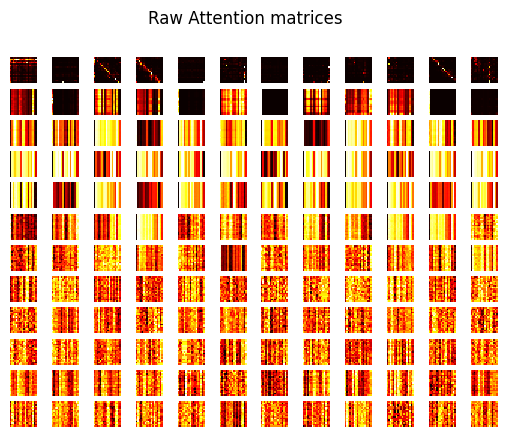

In [74]:
# Let us plot the raw attention matrices for the last training sentence:
fig, axs = plt.subplots(12,12)
fig.suptitle('Raw Attention Matrices')

for i in range(QQ.shape[0]):
    for j in range(QQ.shape[1]):
        axs[i,j].axis('off')
        axs[i,j].imshow(QQ[i,j,:,:], cmap='hot', interpolation='nearest')

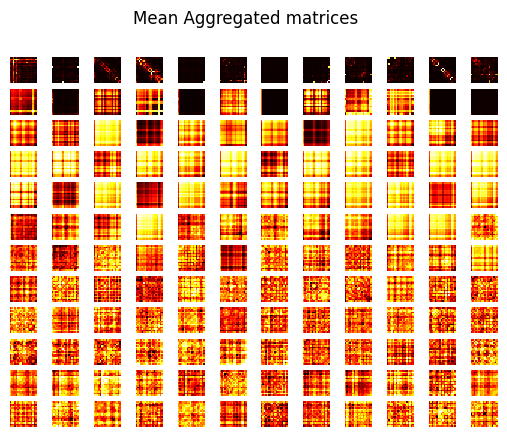

In [75]:
# Let us plot the raw attention matrices for the last training sentence:
fig, axs = plt.subplots(12,12)
fig.suptitle('Mean Aggregated Matrices')

for i in range(all_the_attention_T[-1].shape[0]):
    for j in range(all_the_attention_T[-1].shape[1]):
        axs[i,j].axis('off')
        axs[i,j].imshow(all_the_attention_T[-1][i,j,:,:], cmap='hot', interpolation='nearest')


In [16]:
all_the_attention_V=[]
all_the_labels_V=[]
for _,batch in enumerate(dl_val):
    b_input_ids = batch[0].to(device)
    b_input_mask=attention_mask_from_input(b_input_ids)
    b_labels = batch[1].to(device)
    self_attention = ex.get_activations(b_input_ids)
    for i in range(len(batch[0])):
        klist=[9,26,43,60,77,94,111,128,145,162,179,196]
        keepers=np.where(b_input_mask[i]>0)
        tmp2=keepers[0]
        QQ=np.zeros((12,12,len(tmp2),len(tmp2)))
        for ind_k,k in enumerate(klist):
            tmp=self_attention[k][i].detach().numpy()
            tmp3=tmp[:,tmp2,:]
            QQ[ind_k,:,:,:]=tmp3[:,:,tmp2]
        K=0.5*(QQ+QQ.transpose(0,1,3,2)) # Do the diag fill later as needed
        all_the_attention_V.append(K)
        all_the_labels_V.append(b_labels[i])

### 3.2 Persistence Diagrams

Next we'll compute the Persistent diagrams. We'll use *gudhi* library for this. The specifications are as in the preprint:
1. The filtration value for the undirected edge $(i,j)$ is $1-f(e_{ij},e_{ji})$, where $f$ is the mean of directed edges (See Section 3.2)
2. All the vertices are born at 0; (That is: ```np.fill_diagonal(dm,0)```)
3. All the essential features are set to die at 1; (```d0[np.isinf(d0)] = 1; d1[np.isinf(d1)] = 1```)
4. The maximum dimension is 1. (```max_dimension=1; persistence_dim_max=True)```)

See Figure 3 in the preprint for illustrations.

In [76]:
diagramsh0_train=[]
diagramsh1_train=[]
for i in range(len(all_the_attention_T)):
    graph=all_the_attention_T[i]
    for j in range(graph.shape[0]):
        for k in range(graph.shape[1]):
            dm=1-graph[j,k,:,:]
            np.fill_diagonal(dm,0)
            gudhiC=gRC(distance_matrix=dm)
            simplex_tree = gudhiC.create_simplex_tree(max_dimension=1)
            diag = simplex_tree.persistence(min_persistence=0.0001,persistence_dim_max=True)
            d0=simplex_tree.persistence_intervals_in_dimension(0)
            d1=simplex_tree.persistence_intervals_in_dimension(1)
            d0[np.isinf(d0)] = 1
            d1[np.isinf(d1)] = 1
            diagramsh0_train.append(d0)
            diagramsh1_train.append(d1)

In [77]:
# And same for the validation
diagramsh0_valid=[]
diagramsh1_valid=[]
for i in range(len(all_the_attention_V)):
    graph=all_the_attention_V[i]
    for j in range(graph.shape[0]):
        for k in range(graph.shape[1]):
            dm=1-graph[j,k,:,:]
            np.fill_diagonal(dm,0)
            gudhiC=gRC(distance_matrix=dm)
            simplex_tree = gudhiC.create_simplex_tree(max_dimension=1)
            diag = simplex_tree.persistence(min_persistence=0.0001,persistence_dim_max=True)
            d0=simplex_tree.persistence_intervals_in_dimension(0)
            d1=simplex_tree.persistence_intervals_in_dimension(1)
            d0[np.isinf(d0)] = 1
            d1[np.isinf(d1)] = 1
            diagramsh0_valid.append(d0)
            diagramsh1_valid.append(d1)

### Some Sanity Checks
Let's plot the Persistent diagrams for the attention matrices we checked earlier. Here we plot all the 144 diagrams: At such they are quite difficult to read. Because these change from run to run, you should hand pick some for closer inspection. Take a look at the matrices above, select a few that look different and look at the corresponding diagrams to get intuition how the diagrams turn out to be.

In [96]:
tmp_d0=diagramsh0_train[-144:]
tmp_d1=diagramsh1_train[-144:]

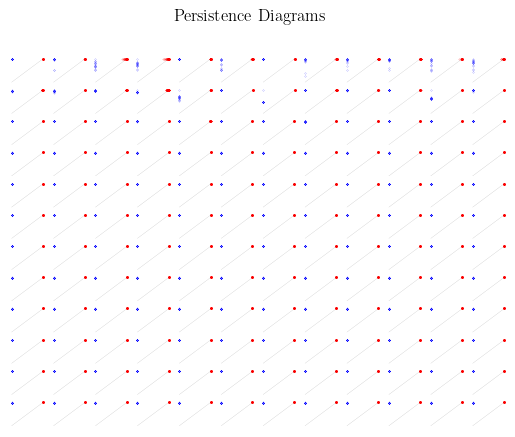

In [113]:
import matplotlib.lines as mlines
fig, axs = plt.subplots(12,12)
fig.suptitle('Persistence Diagrams')
for i in range(12):
    for j in range(12):
        ind=12*i+j
        axs[i,j].axis('off')
        axs[i,j].scatter(tmp_d0[ind][:,0],tmp_d0[ind][:,1],c='blue', s=0.01)
        axs[i,j].scatter(tmp_d1[ind][:,0],tmp_d1[ind][:,1],c='red', s=0.01)
        line = mlines.Line2D([0, 1], [0, 1], color='black', linewidth=0.05)
        axs[i,j].add_line(line)

### 3.3 Persistent Images

We can now compute the Persistent Images. The parameters are adapted from the preprint.

In [114]:
pers0=gPI(bandwidth=0.1, weight=lambda x: 1,im_range=[0,0.01,0,1], resolution=[5,50])
PI0t=pers0.fit_transform(diagramsh0_train)
PI0v=pers0.fit_transform(diagramsh0_valid)
pers1=gPI(bandwidth=0.1, weight=lambda x: 1,im_range=[0,1,0.99,1], resolution=[50,5])
PI1t=pers1.fit_transform(diagramsh1_train)
PI1v=pers1.fit_transform(diagramsh1_valid)

The data from the persistent Image computations is a list, which is not fantastic for bookkeeping. We'll convert the data into proper images of size 5x50 with 288 channels:

In [190]:
## For the sake of transparency, we'll reshape our Persistent Images to size
## (n, 288, 5 ,50), where n is the sample size
## the second dimension is the attention heads concatenated with homology dimension
## This is the same setup as in the preprint, and allows for a direct application of a convolutional neural network
## (note that the simple model in this notebook doesn't make use of this structure)

trainh0=PI0t.reshape(-1,144,250)
trainh0=trainh0.reshape(-1,144,50,5)
trainh0=trainh0.transpose(0,1,3,2)
#the original trainh0=trainh0.reshape(-1,144,5,50)

validh0=PI0v.reshape(-1,144,250)
validh0=validh0.reshape(-1,144,50,5)
validh0=validh0.transpose(0,1,3,2)
#validh0=validh0.reshape(-1,144,5,50)


trainh1=PI1t.reshape(-1,144,250)
trainh1=trainh1.reshape(-1,144,50,5)
trainh1=trainh1.transpose(0,1,3,2)

validh1=PI1v.reshape(-1,144,250)
validh1=validh1.reshape(-1,144,50,5)
validh1=validh1.transpose(0,1,3,2)

test=np.concatenate([trainh0,trainh1],axis=1)
test2=np.concatenate([validh0,validh1],axis=1)

### Some Sanity Checks
Let's have a look at the persistent images for the matrices we saw earlier. Again, you should investigate a specific image to get a better idea of what is going on.

In [191]:
tmp_im0=test[-1,:144,:,:] #H0
tmp_im1=test[-1,144:,:,:] #H1
tmp_im0=tmp_im0.transpose(0,2,1)
tmp_im1=tmp_im1.transpose(0,2,1)

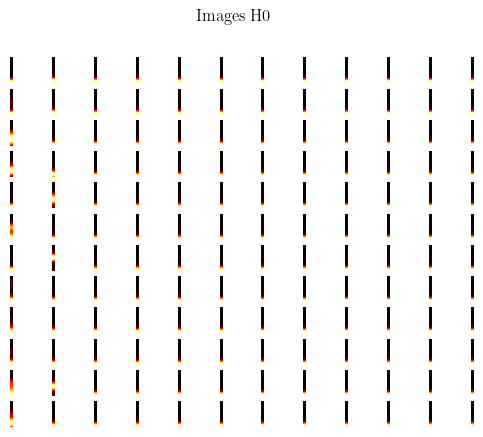

In [192]:
import math
fig, axs = plt.subplots(12,12)
fig.suptitle('Images H0')

for k in range(tmp_im0.shape[0]):
    j=math.floor(k/12)
    i=k%12
    axs[i,j].axis('off')
    axs[i,j].imshow(tmp_im0[k,:,:], cmap='hot', interpolation='nearest')

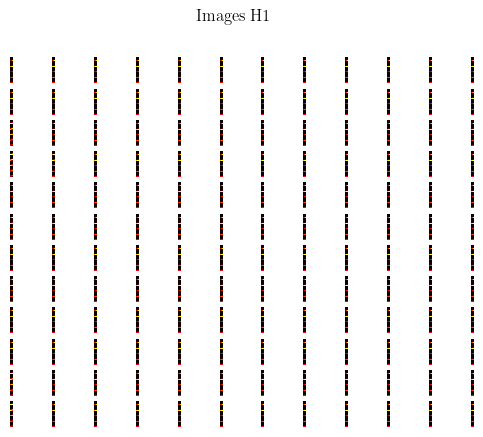

In [193]:
import math
fig, axs = plt.subplots(12,12)
fig.suptitle('Images H1')

for k in range(tmp_im1.shape[0]):
    j=math.floor(k/12)
    i=k%12
    axs[i,j].axis('off')
    axs[i,j].imshow(tmp_im1[k,:,:], cmap='hot', interpolation='nearest')

### A hand-picked example

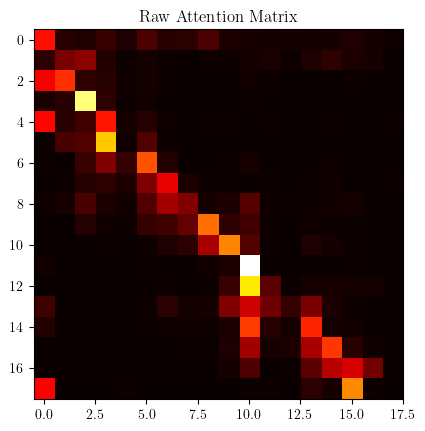

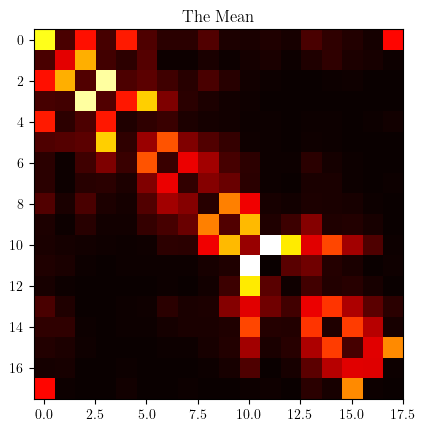

In [202]:
L=0
H=3
k=12*L+H

plt.imshow(QQ[L,H,:,:], cmap='hot', interpolation='nearest')
plt.title("Raw Attention Matrix")
plt.show()

plt.imshow(all_the_attention_T[-1][L,H,:,:], cmap='hot', interpolation='nearest')
plt.title("The Mean")
plt.show()



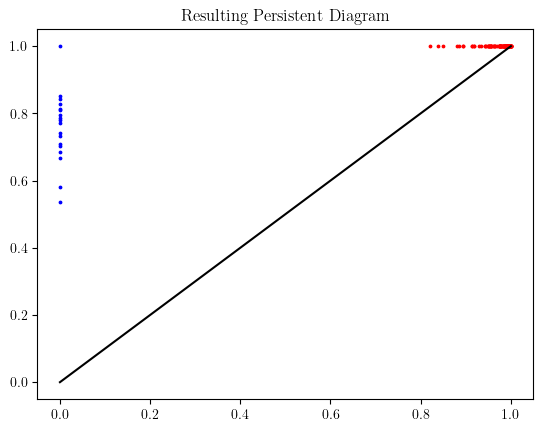

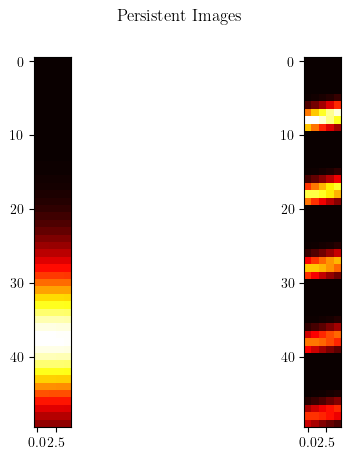

In [203]:
# The persistent diagram from the matrix above:
plt.scatter(tmp_d0[k][:,0],tmp_d0[k][:,1],c='blue', s=3)
plt.scatter(tmp_d1[k][:,0],tmp_d1[k][:,1],c='red', s=3)
plt.plot([0, 1], c='black')
plt.title("Resulting Persistent Diagram")
plt.show()

fig, axs = plt.subplots(1,2)
fig.suptitle("Persistent Images")
axs[0].imshow(tmp_im0[k,:,:], cmap='hot', interpolation='nearest')
axs[1].imshow(tmp_im1[k,:,:], cmap='hot', interpolation='nearest')

## 4. Training a topological model
We'll train a super simple model based on our topological summaries. This follows the usual *giotto-deep* recipe:

In [195]:
dl_builder2 = DataLoaderBuilder((FromArray(test, train_labels), FromArray(test2, validation_labels)))
dl_tr2, dl_val2, _ = dl_builder2.build(({"batch_size": 8}, {"batch_size": 8}))

In [196]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(288*50*5,2)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = x.type(torch.FloatTensor)
        x = self.linear(x)
        return x


net = Net()



criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.000067)

In [197]:
pipe2 = Trainer(net, (dl_tr2, dl_val2), criterion, writer)

In [198]:
pipe2.train(
    Adam,
    20,
    False,
    lr_scheduler=ExponentialLR,
    scheduler_params={"gamma": 0.9},
    profiling=False,
    store_grad_layer_hist=True,
    writer_tag="line",
)

Epoch 1
-------------------------------
Epoch training loss: 305.927872 	Epoch training accuracy: 45.83%                                            
Time taken for this epoch: 0.00s
Learning rate value: 0.00100000
Validation results: 
 accuracy: 62.50%,                 Avg loss: 24.397763 

Epoch 2
-------------------------------
Epoch training loss: 64.898544 	Epoch training accuracy: 64.81%                                             
Time taken for this epoch: 0.00s
Learning rate value: 0.00090000
Validation results: 
 accuracy: 36.31%,                 Avg loss: 85.432853 

Epoch 3
-------------------------------
Epoch training loss: 131.731432 	Epoch training accuracy: 57.41%                                             
Time taken for this epoch: 0.00s
Learning rate value: 0.00081000
Validation results: 
 accuracy: 45.24%,                 Avg loss: 36.795739 

Epoch 4
-------------------------------
Epoch training loss: 181.166746 	Epoch training accuracy: 51.39%                   

(19.616119827542985, 53.57142857142857)

## 5. Pruning the Model

The topological model we just defined is quite transparent in that we can easily define importance metrics for the attention heads (in essence, these are just features we fed to the model). We'll follow the importance metrics used in the preprint, namely:

In [146]:
tmp1=torch.FloatTensor(test)
train_labels=torch.FloatTensor(train_labels)
validation_labels=torch.FloatTensor(validation_labels)
train_labels = train_labels.type(torch.LongTensor)
validation_labels = validation_labels.type(torch.LongTensor)
batch_size=3
tmp2=torch.FloatTensor(test2)
tmp2.requires_grad=True
ds1 = TensorDataset(tmp1, train_labels)
ds2 = TensorDataset(tmp2, validation_labels)
trainloader = torch.utils.data.DataLoader(ds1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(ds2, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [147]:
# Let's compute some gradients
imageset=trainloader.dataset[0:500][0]
target_label=trainloader.dataset[0:500][1]
a = torch.autograd.Variable(imageset)
a.requires_grad=True
outputs=net(a)
target_label
loss = criterion(outputs,target_label)

In [148]:
a_grad = torch.autograd.grad(loss, a, retain_graph=True)

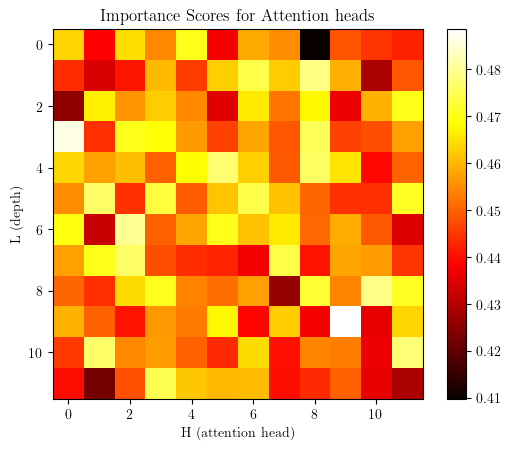

In [149]:
tmp=np.sum(abs(a_grad[0].detach().cpu().numpy()), axis=(0,2,3))
tmp2=tmp[0:144]+tmp[144:] # Average over hom.dim (H0+H1)
#tmp2
tmp3=tmp2.reshape(12,12) # Unpack for plotting
plt.imshow(tmp3, cmap='hot', interpolation='nearest')
plt.ylabel('L (depth)')
plt.xlabel('H (attention head)')
plt.title('Importance Scores for Attention heads')
plt.colorbar()
plt.show()

We can now select the most impactful however many heads we want. In the code below we take the top 100. We'll stick to the simple model we used earlier, so you only need to change
```
heads_to_keep
```
in the code chunk below to select however many heads you want.

In [150]:
heads_to_keep=100
pruned_indices=np.argsort(tmp2)[-heads_to_keep:]

In [151]:
trainprunedh0=trainh0[:,pruned_indices,:,:]
trainprunedh1=trainh1[:,pruned_indices,:,:]
validprunedh0=validh0[:,pruned_indices,:,:]
validprunedh1=validh1[:,pruned_indices,:,:]

test=np.concatenate([trainprunedh0,trainprunedh1],axis=1)
test2=np.concatenate([validprunedh0,validprunedh0],axis=1)
test= test.astype(np.float32)
test2= test2.astype(np.float32)
tmp1=torch.FloatTensor(test)
tmp2=torch.FloatTensor(test2)
tmp2.requires_grad=True
ds1 = TensorDataset(tmp1, train_labels)
ds2 = TensorDataset(tmp2, validation_labels)

In [152]:
trainloader = torch.utils.data.DataLoader(ds1, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(ds2, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [153]:
dl_builder2 = DataLoaderBuilder((FromArray(test, train_labels), FromArray(test2, validation_labels)))
dl_tr2, dl_val2, _ = dl_builder2.build(({"batch_size": 8}, {"batch_size": 8}))

In [154]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(2*heads_to_keep*50*5,2)

    def forward(self, x):
        x = torch.flatten(x, 1) 
        x = self.linear(x)
        return x


net = Net()

criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.000067)

In [155]:
pipe2 = Trainer(net, (dl_tr2, dl_val2), criterion, writer)
# train the model with learning rate scheduler
pipe2.train(
    Adam,
    20,
    False,
    lr_scheduler=ExponentialLR,
    scheduler_params={"gamma": 0.9},
    profiling=False,
    store_grad_layer_hist=True,
    writer_tag="line",
)

Epoch 1
-------------------------------
Epoch training loss: 220.237795 	Epoch training accuracy: 58.33%                                    
Time taken for this epoch: 0.00s
Learning rate value: 0.00100000


/home/safari/Documents/research/giotto-tda/deep/giotto-deep/gdeep/trainer/trainer.py:468: UserWarning:

Cannot store data in the PR curve



Validation results: 
 accuracy: 45.83%,                 Avg loss: 427.717486 

Epoch 2
-------------------------------
Epoch training loss: 125.658745 	Epoch training accuracy: 47.22%                                             
Time taken for this epoch: 0.00s
Learning rate value: 0.00090000
Validation results: 
 accuracy: 45.24%,                 Avg loss: 235.236406 

Epoch 3
-------------------------------
Epoch training loss: 80.854943 	Epoch training accuracy: 48.15%                                            
Time taken for this epoch: 0.00s
Learning rate value: 0.00081000
Validation results: 
 accuracy: 47.62%,                 Avg loss: 46.285090 

Epoch 4
-------------------------------
Epoch training loss: 58.445333 	Epoch training accuracy: 53.70%                                             
Time taken for this epoch: 0.00s
Learning rate value: 0.00072900
Validation results: 
 accuracy: 54.17%,                 Avg loss: 132.237235 

Epoch 5
-------------------------------
Epo

(16.67169952392578, 52.38095238095237)

## Conclusion

In this tutorial, we used *giotto-deep* to
1. Fit an off the shelf Huggingface model;
2. Fine tune it;
3. Extract its inner workings to;
4. construct a pruned model.

Depending on the choices made along the way, the pruned model may be anything from strong to terrible. To increase performance, you may

1. Add more data (remember this notebook is heavily subsampled);
2. Spend more time fine-tuning the BERT; 
3. Fit more complicated models;
4. Optimize the parameters.
